In [1]:
import tensorflow as tf
import os
import cv2
import json
import numpy as np
from matplotlib import pyplot as plt
from keras.applications import InceptionResNetV2
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.metrics import Precision, Recall, SparseCategoricalAccuracy

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

Num GPUs Available:  1
1 Physical GPUs, 1 Logical GPUs


In [3]:
base_dir = "Car Makes"
img_size = (224, 224)
batch_size = 16

data = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='int',
    interpolation='bilinear'
)

class_names = data.class_names
print("Class names:", class_names)
with open('CarBackEnd/mappings/CarBrandMake map.json', 'w') as f:
    json.dump(class_names, f)

data_iterator = data.as_numpy_iterator()

Found 283317 files belonging to 38 classes.
Class names: ['acura', 'audi', 'bmw', 'buick', 'cadillac', 'chevrolet', 'chrysler', 'dodge', 'ford', 'gmc', 'honda', 'hyundai', 'infiniti', 'isuzu', 'jaguar', 'jeep', 'kia', 'landrover', 'lexus', 'lincoln', 'mazda', 'mercedes benz', 'mercury', 'mini', 'mitsubishi', 'nissan', 'oldsmobile', 'plymouth', 'pontiac', 'porsche', 'saab', 'saturn', 'scion', 'subaru', 'suzuki', 'toyota', 'volkswagen', 'volvo']


In [4]:
batch = data_iterator.next()
num_classes = len(class_names)

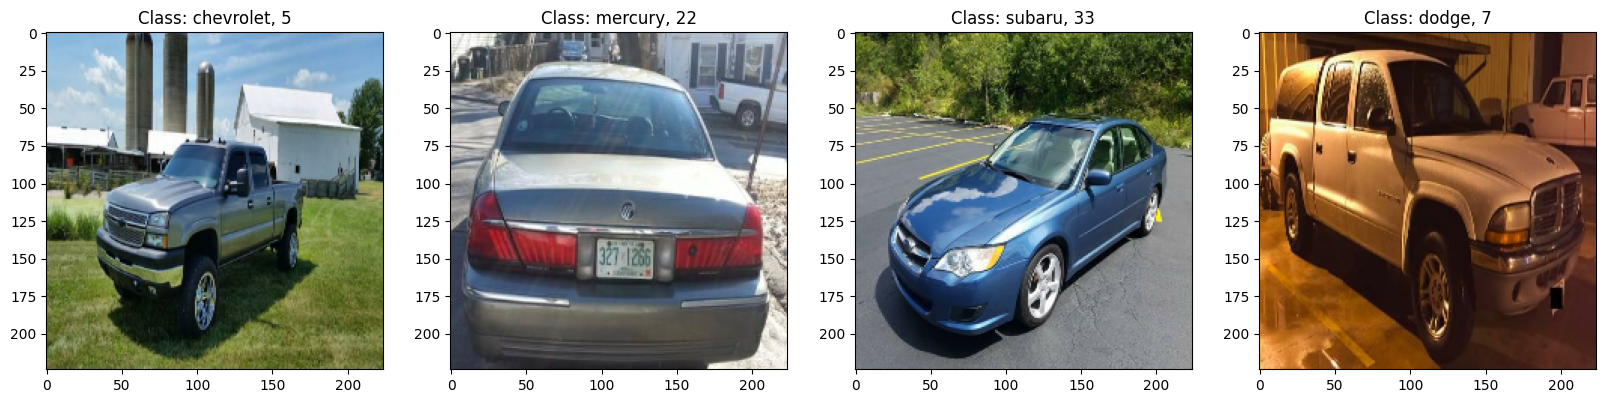

In [5]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(f"Class: {class_names[batch[1][idx]]}, {batch[1][idx]}")

In [6]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [7]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [9]:
base_model = InceptionResNetV2(
    weights='imagenet',                    
    include_top=False,
    input_shape=(224, 224, 3)
)
base_model.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_203 (Conv2D)            (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_203 (Batch  (None, 111, 111, 32  96         ['conv2d_203[0][0]']             
 Normalization)                 )                                               

In [9]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer='adam', 
          loss='sparse_categorical_crossentropy', 
          metrics=['accuracy'])
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='logs')
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
12395/12395 [==============================] - 1239s 99ms/step - loss: 1.6397 - accuracy: 0.5432 - val_loss: 1.2935 - val_accuracy: 0.6473
Epoch 2/20
12395/12395 [==============================] - 1209s 97ms/step - loss: 0.7519 - accuracy: 0.7834 - val_loss: 0.7386 - val_accuracy: 0.7885
Epoch 3/20
12395/12395 [==============================] - 1207s 97ms/step - loss: 0.4837 - accuracy: 0.8568 - val_loss: 0.6533 - val_accuracy: 0.8195
Epoch 4/20
12395/12395 [==============================] - 1205s 97ms/step - loss: 0.3388 - accuracy: 0.8976 - val_loss: 0.6287 - val_accuracy: 0.8319
Epoch 5/20
12395/12395 [==============================] - 1207s 97ms/step - loss: 0.2492 - accuracy: 0.9231 - val_loss: 0.6889 - val_accuracy: 0.8309
Epoch 6/20
12395/12395 [==============================] - 1209s 98ms/step - loss: 0.1908 - accuracy: 0.9398 - val_loss: 0.7188 - val_accuracy: 0.8317
Epoch 7/20
12395/12395 [==============================] - 1218s 98ms/step - loss: 0.1505 - accuracy:

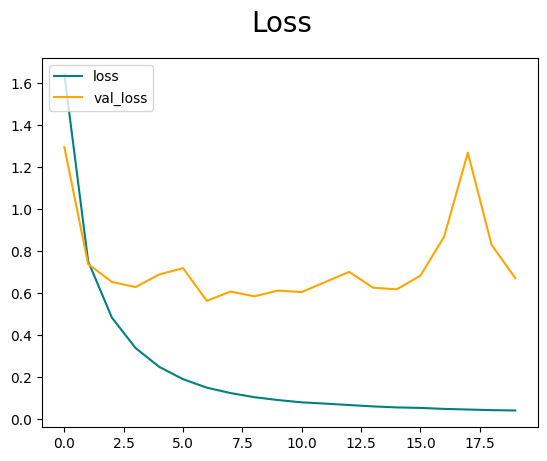

In [10]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)    
plt.legend(loc="upper left")
plt.show()

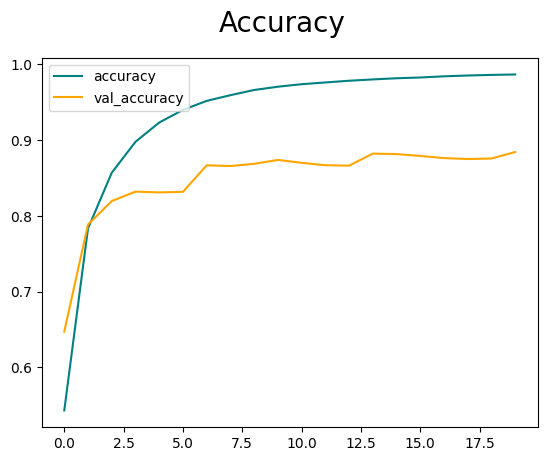

In [11]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [12]:
pre = Precision()
re = Recall()
acc = SparseCategoricalAccuracy()

In [13]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    
    yhat_classes = tf.argmax(yhat, axis=1)
    
    pre.update_state(y, yhat_classes)
    re.update_state(y, yhat_classes)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 31ms/step


In [14]:
print(f"Precision: {pre.result().numpy() * 100 : .2f}%")
print(f"Recall: {re.result().numpy() * 100 : .2f}%")
print(f"Accuracy: {acc.result().numpy() * 100 : .2f}%")

Precision:  99.82%
Recall:  99.62%
Accuracy:  88.76%


1/1 [==============================] - 2s 2s/step


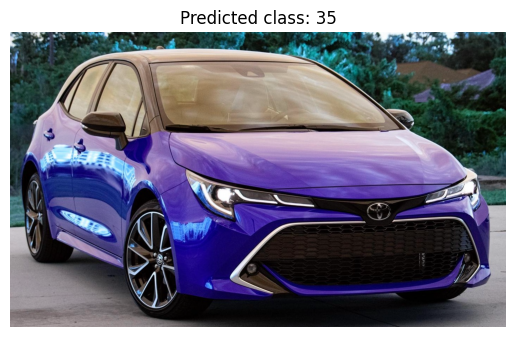

In [15]:
img = cv2.imread('Styles/test/Hatchback/8_jpg.rf.c314c1d6777942876503fa1482c82240.jpg')

img_resized = cv2.resize(img, img_size)
img_expanded = np.expand_dims(img_resized, axis=0)

yhat = model.predict(img_expanded)
predicted_class = tf.argmax(yhat, axis=1).numpy()[0]

plt.imshow(img) 
plt.title(f'Predicted class: {predicted_class}')
plt.axis('off') 
plt.show()

In [16]:
print(f'Predicted class is: {class_names[predicted_class]}')

Predicted class is: toyota


In [17]:
model_file_name = f"CarBrandMakeModel{acc.result().numpy() * 100 : .2f}% InceptionResNetV2.h5"
model.save(os.path.join('CarBackEnd/models/CarBrandsMakes', model_file_name))